https://github.com/gusmartinezr/IASIS421/tree/main/Examen

https://drive.google.com/drive/folders/17lGKg0bJzxNiTZ6ND21_TLCj_Rni5VNS?usp=sharing

In [1]:
# importar las librerias 
import os
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import cv2 

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
image_path = '/content/drive/MyDrive/IA2/DatasetBasura/'
directorio = os.listdir(image_path) 
directorio

['cartones',
 'Plastoformos',
 'BolsasPlasticas',
 'botellas_de_plastico',
 'EnvasesPlasticos']

In [4]:
clases = {'cartones':0, 'Plastoformos':1, 'BolsasPlasticas':2, 'botellas_de_plastico':3, 'EnvasesPlasticos':4} 
clases

{'BolsasPlasticas': 2,
 'EnvasesPlasticos': 4,
 'Plastoformos': 1,
 'botellas_de_plastico': 3,
 'cartones': 0}

In [5]:
imgs, labels = [], []
size = 32
for img in directorio: # recorremos elcorchetes direcotior
  imagenes = os.listdir(image_path + img)
  #print(paths)
  for i in imagenes:
    dir_imagenes = image_path + img + '/' + i #
    #print(dir_imagenes)
    #open_images = Image.open(dir_imagenes)
    #resize_image = open_images.resize((size, size)) 
    imgs.append(dir_imagenes)
    #print(img_array)
    labels.append(clases[img])

In [6]:
X_train = imgs
y_train = labels 

In [7]:
def getName(label):
  for key in clases:
      if clases[key] == label:
        return(key)

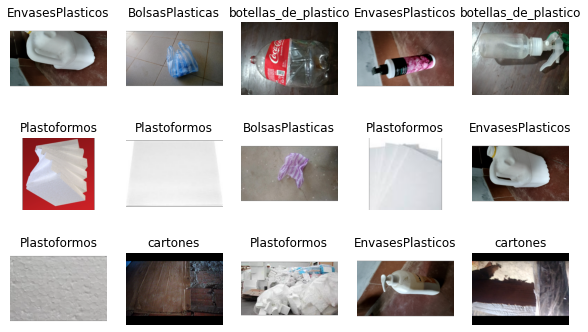

In [8]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(X_train)-1)
    img = io.imread(X_train[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(getName(y_train[ix]))
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(X_train, y_train, test_size=0.10, stratify=y_train)

len(train_imgs), len(test_imgs)

(4994, 555)

In [10]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
    # self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img1 = Image.open(self.X[ix]).convert('RGB')
    new_img = img1.resize((32,32))
    #images.append(np.array(new_img)/255)
    return torch.from_numpy((np.array(new_img))/255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [11]:
dataset = {
    'train': Dataset(train_imgs, train_labels), 
    'test': Dataset(test_imgs, test_labels)
}
X_train = dataset['train']
X_test = dataset['test']
X_train

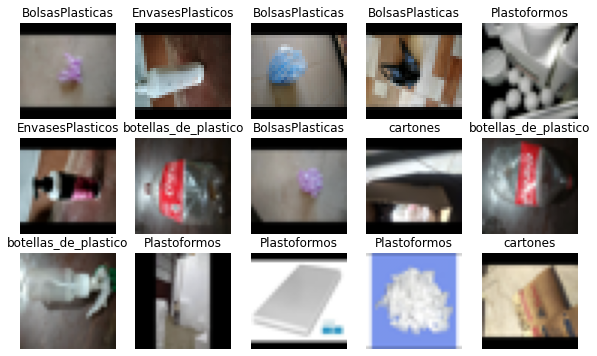

In [12]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(getName(lab))
plt.show()

In [13]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=64, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 32, 32])

In [15]:
import torchvision
wide_net = torchvision.models.wide_resnet50_2()
wide_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [16]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos wide_net
    wide_net = torchvision.models.wide_resnet50_2(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.wide_net  = torch.nn.Sequential(*list(wide_net.children())[:-1])
    if freeze:
      for param in self.wide_net.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(2048, 5)

  def forward(self, x):
    x = self.wide_net(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.wide_net.parameters():
        param.requires_grad=True

In [17]:
model = Model()
outputs = model(torch.randn(64, 3, 32, 32))
outputs.shape

torch.Size([64, 5])

In [18]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [19]:
import torch
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
model = Model()
fit(model, dataloader, epochs=5)

val_loss nan val_acc 0.18560: 100%|██████████| 9/9 [00:51<00:00,  5.74s/it]


Epoch 1/5 loss 0.79170 val_loss nan acc 0.73536 val_acc 0.18560


val_loss 62408.23872 val_acc 0.18128: 100%|██████████| 9/9 [00:20<00:00,  2.30s/it]


Epoch 2/5 loss 26321.83591 val_loss 62408.23872 acc 0.34078 val_acc 0.18128


val_loss 80087.26780 val_acc 0.24883: 100%|██████████| 9/9 [00:20<00:00,  2.28s/it]


Epoch 3/5 loss 13346.69966 val_loss 80087.26780 acc 0.49407 val_acc 0.24883


val_loss 71352.64627 val_acc 0.36592: 100%|██████████| 9/9 [00:20<00:00,  2.30s/it]


Epoch 4/5 loss 8938.21373 val_loss 71352.64627 acc 0.56329 val_acc 0.36592


val_loss 24777.57726 val_acc 0.30176: 100%|██████████| 9/9 [00:20<00:00,  2.28s/it]

Epoch 5/5 loss 6253.54304 val_loss 24777.57726 acc 0.61669 val_acc 0.30176


Tranfer Learning 

In [ ]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

val_loss 1.22592 val_acc 0.47182: 100%|██████████| 9/9 [00:20<00:00,  2.29s/it]


Epoch 1/5 loss 1.20805 val_loss 1.22592 acc 0.57634 val_acc 0.47182


val_loss 1.05718 val_acc 0.58366: 100%|██████████| 9/9 [00:20<00:00,  2.30s/it]


Epoch 2/5 loss 0.88235 val_loss 1.05718 acc 0.72369 val_acc 0.58366


val_loss 0.94481 val_acc 0.63307: 100%|██████████| 9/9 [00:20<00:00,  2.28s/it]


Epoch 3/5 loss 0.76292 val_loss 0.94481 acc 0.76345 val_acc 0.63307


loss 0.69019 acc 0.78563:  32%|███▏      | 25/79 [01:01<02:13,  2.47s/it]

Fine Tunning


In [ ]:
model = Model(pretrained=True, freeze=False)
fit(model, dataloader)

In [ ]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=1e-4)